This competition is to predict the classes of leaves. The number of classes is 176, we will have 18k training data, and test it on 8800 data. This notebook aims to share my experience on the competition.

#Mount Drive and Import

Check what GPU is provided. Mine is Tesla P100 provided by Colab Pro.

In [2]:
!nvidia-smi

Fri Sep 24 01:22:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

I downloaded the dataset ('classify-leaves.zip') into my google drive, so I mount google drive on colab, and I can read the data from there.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Unzip the file into the current directory

In [ ]:
!unzip gdrive/MyDrive/classify-leaves.zip

Install all dependencies

In [ ]:
!pip install albumentations --upgrade
!pip install timm
!pip install ttach
!pip install pytorch-metric-learning
!pip install imagehash
!pip install torchinfo
!pip install torch-lr-finder

In [19]:
!pip install thop

In [22]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import os
import cv2
import timm

import albumentations
from albumentations import pytorch as AT

#below are all from https://github.com/seefun/TorchUtils, thanks seefun to provide such useful tools
import torch_utils as tu

#Load Data

In [23]:
CLEAN_DATASET = 0
FOLD = 5
csv = pd.read_csv('clean_train_v4.csv') if CLEAN_DATASET else pd.read_csv('train.csv') #cleaned data has no obvious improvement
sfolder = StratifiedKFold(n_splits=FOLD,random_state=709,shuffle=True)
train_folds = []
val_folds = []
for train_idx, val_idx in sfolder.split(csv['image'], csv['label']):
  train_folds.append(train_idx)
  val_folds.append(val_idx)
  print(len(train_idx), len(val_idx))

14682 3671
14682 3671
14682 3671
14683 3670
14683 3670


In [24]:
labelmap_list = sorted(list(set(csv['label']))) #sorting is necessary to reproduce the order of the labelmap
labelmap = dict()
for i, label in enumerate(labelmap_list):
  labelmap[label] = i
print(labelmap)

{'abies_concolor': 0, 'abies_nordmanniana': 1, 'acer_campestre': 2, 'acer_ginnala': 3, 'acer_griseum': 4, 'acer_negundo': 5, 'acer_palmatum': 6, 'acer_pensylvanicum': 7, 'acer_platanoides': 8, 'acer_pseudoplatanus': 9, 'acer_rubrum': 10, 'acer_saccharinum': 11, 'acer_saccharum': 12, 'aesculus_flava': 13, 'aesculus_glabra': 14, 'aesculus_hippocastamon': 15, 'aesculus_pavi': 16, 'ailanthus_altissima': 17, 'albizia_julibrissin': 18, 'amelanchier_arborea': 19, 'amelanchier_canadensis': 20, 'amelanchier_laevis': 21, 'asimina_triloba': 22, 'betula_alleghaniensis': 23, 'betula_jacqemontii': 24, 'betula_lenta': 25, 'betula_nigra': 26, 'betula_populifolia': 27, 'broussonettia_papyrifera': 28, 'carpinus_betulus': 29, 'carpinus_caroliniana': 30, 'carya_cordiformis': 31, 'carya_glabra': 32, 'carya_ovata': 33, 'carya_tomentosa': 34, 'castanea_dentata': 35, 'catalpa_bignonioides': 36, 'catalpa_speciosa': 37, 'cedrus_atlantica': 38, 'cedrus_deodara': 39, 'cedrus_libani': 40, 'celtis_occidentalis': 41

Define the Dataset, the transformation, and the dataloaders. Moreover, I wrote a function to visualize the transformation.

In [25]:
class LeavesDataset(Dataset):
  def __init__(self, csv, transform=None):
    self.csv = csv
    self.transform = transform
  
  def __len__(self):
    return len(self.csv['image'])
  
  def __getitem__(self, idx):
    img = cv2.imread(self.csv['image'][idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = labelmap[self.csv['label'][idx]]
    if self.transform:
      img = self.transform(image = img)['image']
    return img, torch.tensor(label).type(torch.LongTensor)

def create_dls(train_csv, test_csv, train_transform, test_transform, bs, num_workers):
  train_ds = LeavesDataset(train_csv, train_transform)
  test_ds = LeavesDataset(test_csv, test_transform)
  train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=True)
  test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False)
  return train_dl, test_dl, len(train_ds), len(test_ds)

Define the transformations. Note that I resized the image to 112x112, which should be 224x224 in standard, but I just wanted to shorten the training time by half. By resizing the image to 224x224, the performance should be a little bit higher, and if you want to climb the LB, it worths it.

In [26]:
train_transform1 = albumentations.Compose([
    albumentations.Resize(112, 112, interpolation=cv2.INTER_AREA),
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.0625, rotate_limit=45, border_mode=1, p=0.5),
    #tu.randAugment(N=2,M=6,p=1,cut_out=True),    
    albumentations.Normalize(),
    AT.ToTensorV2(),
    ])
    
test_transform1 = albumentations.Compose([
    albumentations.Resize(112, 112, interpolation=cv2.INTER_AREA),
    albumentations.Normalize(),
    AT.ToTensorV2(),
    ])

Test dataset


I could combine this with the training dataset class, but I am just a little bit lazy.

In [27]:
class LeavesTestDataset(Dataset):
  def __init__(self, csv, transform=None):
    self.csv = csv
    self.transform = transform
  
  def __len__(self):
    return len(self.csv['image'])
  
  def __getitem__(self, idx):
    img = Image.open(self.csv['image'][idx])
    if self.transform:
      img = self.transform(img)
    return img

def create_testdls(test_csv, test_transform, bs):
  test_ds = LeavesTestDataset(test_csv, test_transform)
  test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=2)
  return test_dl

transform_test = transforms.Compose([
        transforms.Resize((112,112)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

In [28]:
def show_img(x):
  trans = transforms.ToPILImage()
  mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
  std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
  x = (x*std)+mean
  x_pil = trans(x)
  return x_pil

Show images with the first fold data

In [29]:
train_csv = csv.iloc[train_folds[0]].reset_index()
val_csv = csv.iloc[val_folds[0]].reset_index()

In [30]:
train_dl, val_dl, n_train, n_val = create_dls(train_csv, val_csv, train_transform=train_transform1, test_transform=test_transform1, bs=64, num_workers=4)

In [31]:
#mixup_fn = Mixup(prob=1., switch_prob=0.0, onehot=True, label_smoothing=0.05, num_classes=176)
for x, y in train_dl:
  #imgs_train, labels_train = mixup_fn(x, y)
  break

In [32]:
y.shape

torch.Size([64])

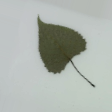

In [33]:
show_img((x[2]))

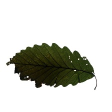

In [34]:
show_img((x[3]))

#Model

Define the model. We use the pretrained model either from timm or torchvision. I prefer resnet50d because it can achieve better results than the original resnet, and is fast, much faster than seresnext50_32x4d and tf_efficientnetv2_l_in21ft1k. 

After loading the pretrained model, we have to change the output layer number to the 176, the number of leaf classes, and initilze it with xavier initilisation.

In [35]:
#model = torchvision.models.resnet50(pretrained=True)
#model = torchvision.models.resnext101_32x8d(pretrained=True)
#model = timm.create_model('seresnext50_32x4d', pretrained=True)
model = timm.create_model('resnet50d', pretrained=True)
#model = timm.create_model('resnest50d', pretrained=True)

#model = timm.create_model('tf_efficientnetv2_l_in21ft1k', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth


In [36]:
model.fc = nn.Linear(model.fc.in_features, len(labelmap_list))
nn.init.xavier_uniform_(model.fc.weight);

In [37]:
model.cuda()
device = 'cuda'

#Optimizer, loss

Use label smoothing in loss function.

Use AdamW as our optimizer, which is marginally better than Adam. Note that we make 2 param_groups in the optimizer because we try to update the CNN layers much slower than the last fc layer.

In [38]:
class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [39]:
params_1x = [param for name, param in model.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
lr = 5e-4

optimizer = torch.optim.AdamW([{'params': params_1x},
                                   {'params': model.fc.parameters(),
                                    'lr': lr * 10}],
                                lr=lr, weight_decay=0.001) #finetuning
'''
from optim import RangerLars
optimizer = RangerLars([{'params': params_1x},
                        {'params': model.fc.parameters(),
                                    'lr': lr * 10}], lr=lr, weight_decay=0.001)
'''
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)

loss_fn = LabelSmoothing(0.1)

#Find the LR

In [40]:
import math
import matplotlib.pyplot as plt
import numpy as np

def find_lr(model, factor, train_dl, optimizer, loss_fn, device, init_lr=1e-8, final_lr=1e-1, beta=0.98, plot=True, save_dir=None):
    num = len(train_dl) - 1
    mult = (final_lr / init_lr) ** (1/num)
    lr = init_lr
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    scaler = torch.cuda.amp.GradScaler() # for AMP training 

    if 1:
      for x, y in train_dl:
          x, y = x.to(device), y.to(device)
          batch_num += 1
          optimizer.zero_grad()
          with torch.cuda.amp.autocast():
            out = model(x)
            loss = loss_fn(out, y)
          #smoothen the loss
          avg_loss = beta * avg_loss + (1-beta) * loss.data.item() #check
          smoothed_loss = avg_loss / (1 - beta**batch_num) #bias correction
          #stop if loss explodes
          if batch_num > 1 and smoothed_loss > 4 * best_loss: #prevents explosion
              break
          #record the best loss
          if smoothed_loss < best_loss or batch_num == 1:
              best_loss = smoothed_loss
          #store the values
          losses.append(smoothed_loss)
          log_lrs.append(math.log10(lr))
          #do the sgd step
          #loss.backward()
          #optimizer.step()
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
          #update the lr for the next step
          lr *= mult
          optimizer.param_groups[0]['lr'] = lr
    #Suggest a learning rate
    log_lrs, losses = np.array(log_lrs), np.array(losses)
    idx_min = np.argmin(losses)
    min_log_lr = log_lrs[idx_min]
    lr_auto = (10 ** (min_log_lr)) /factor
    if plot:
        selected = [np.argmin(np.abs(log_lrs - (min_log_lr-1)))] #highlight the suggested lr
        plt.figure()
        plt.plot(log_lrs, losses,'-gD', markevery=selected)
        plt.xlabel('log_lrs')
        plt.ylabel('loss')
        plt.title('LR Range Test')
        if save_dir is not None:
            plt.savefig(f'{save_dir}/lr_range_test.png')
        else:
            plt.savefig(f'lr_range_test.png')
    return lr_auto


In [ ]:
#lr_suggested = find_lr(model, 100, train_dl, optimizer, loss_fn, 'cuda', init_lr=1e-10, final_lr=1.) #run if u want suggestion from autolr

In [ ]:
#lr_suggested

Re-initilise the model

In [41]:
def get_learner(lr, nb, epochs, model_name='resnet50d', MIXUP=0.1):
  mixup_fn = tu.Mixup(prob=MIXUP, switch_prob=0.0, onehot=True, label_smoothing=0.05, num_classes=len(labelmap_list))
  model = timm.create_model(model_name, pretrained=True)
  model.fc = nn.Linear(model.fc.in_features, len(labelmap_list))
  nn.init.xavier_uniform_(model.fc.weight)
  model.cuda()

  params_1x = [param for name, param in model.named_parameters()
              if name not in ["fc.weight", "fc.bias"]]

  optimizer = torch.optim.AdamW([{'params': params_1x},
                                    {'params': model.fc.parameters(),
                                      'lr': lr*10}],
                                  lr=lr, weight_decay=2e-4)

  loss_fn = tu.SoftTargetCrossEntropy() if MIXUP else LabelSmoothing(0.1)
  loss_fn_test = F.cross_entropy
  '''
  import math
  def warmup_one_cycle(y1=0.0, y2=1.0, steps=100, warmup_steps=0): #no warmup is better experimentally
          #sinusoidal ramp from y1 to y2 https://arxiv.org/pdf/1812.01187.pdf
          return lambda x: x / warmup_steps if x < warmup_steps \
                          else ((1 - math.cos((x-warmup_steps) * math.pi / steps)) / 2) * (y2 - y1) + y1

  lf = warmup_one_cycle(1, 0.2, epochs*nb, 3*nb)
  #lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf) 
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5*nb, eta_min=lr_suggested/100)
  '''
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*nb, eta_min=lr/20)
  return model, optimizer, loss_fn, loss_fn_test, lr_scheduler, mixup_fn

In [ ]:
'''
#visualize the lr scheduler
lr1s = []
lr2s = []
for epoch in range(epochs):
  for i in range(nb):
    lr_scheduler.step()
    lr1s.append(optimizer.param_groups[0]['lr'])
    #lr2s.append(optimizer.param_groups[1]['lr'])
import matplotlib.pyplot as plt
plt.plot(lr1s)
#plt.plot(lr2s)
'''

"\n#visualize the lr scheduler\nlr1s = []\nlr2s = []\nfor epoch in range(epochs):\n  for i in range(nb):\n    lr_scheduler.step()\n    lr1s.append(optimizer.param_groups[0]['lr'])\n    #lr2s.append(optimizer.param_groups[1]['lr'])\nimport matplotlib.pyplot as plt\nplt.plot(lr1s)\n#plt.plot(lr2s)\n"

38, 55.91

#Train

Train the model with the above settings. Save the best model once we achieved a better validation score. Note that we use gradscaler and autocast to do mixed-precision traininig, and it is only useful for a handful GPUs, most commonly T4 and V100. But if you don't have those GPUs, dont worry, it will do nno harm.

In [ ]:
#Start training
import time
import ttach as tta
device = 'cuda'
save_dir = './gdrive/MyDrive/kaggle_leave_classification/'
#map from idx to string
labelmap_inverse = dict()
for key_ in labelmap.keys():
  labelmap_inverse[labelmap[key_]] = key_
EPOCHS = 50
MIXUP = 0.1
 
scaler = torch.cuda.amp.GradScaler() # for AMP training 

for fold in range(FOLD):
  print(f'Start Fold{fold}...')
  train_csv = csv.iloc[train_folds[2]].reset_index()
  val_csv = csv.iloc[val_folds[2]].reset_index()
  train_dl, val_dl, n_train, n_val = create_dls(train_csv, val_csv, train_transform=train_transform1, test_transform=test_transform1, bs=64, num_workers=4)
  model, optimizer, loss_fn, loss_fn_test, lr_scheduler, mixup_fn = get_learner(3e-4, len(train_dl), EPOCHS, model_name='resnet50d', MIXUP=MIXUP)
  model_name = f'5fold_test_fold{fold}'
  train_losses = [] 
  val_losses = []
  train_accus = []
  val_accus = []
  best_accu = 0
  best_loss = float('inf')
  lrs = []
  for epoch in range(EPOCHS):
          t1 = time.time()
          val_accu = 0
          train_accu = 0
          train_losses_tmp = []
          #Train
          model.train()
          t_inf = 0
          for x, y in train_dl:
              if MIXUP:
                x, y = mixup_fn(x, y)
              x, y = x.to(device), y.to(device)
              #Forward
              with torch.cuda.amp.autocast():
                pred = model(x)
                loss = loss_fn(pred, y)
              #Backward
              #loss.backward()
              #optimizer.step()
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()
              lr_scheduler.step()
              optimizer.zero_grad()
              #Statistics
              lrs.append(optimizer.param_groups[0]['lr']) #group 0,1,2 share the learning rate
              train_losses_tmp.append(loss.data.item())
              pred_labels = torch.argmax(pred.data, dim=1)
              y_labels = torch.argmax(y.data, dim=1) if MIXUP else y.data
              train_accu += (pred_labels==y_labels).float().sum()
          t_inf /= len(train_dl)
          train_losses.append(np.mean(np.array(train_losses_tmp)))
          train_accu /= n_train
          train_accus.append(train_accu.data.item())

          t2 = time.time()
          #Validation
          val_losses_tmp = []
          model.eval()
          with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                logit = model(x)
                val_loss = loss_fn_test(logit, y) 
                val_losses_tmp.append(val_loss.data.item())
                pred = torch.argmax(logit.data, dim=1)
                val_accu += (pred==y.data).float().sum()
          t3 = time.time()
          val_loss = np.mean(np.array(val_losses_tmp))
          val_losses.append(val_loss)
          val_accu /= n_val
          val_accus.append(val_accu.data.item())
          print('fold', fold, 'epoch', epoch, 'train_loss', train_losses[epoch], 'val_loss', val_losses[epoch], 'val_accu', val_accu, 'train_accu', train_accu, 'train time', t2-t1, 'val time', t3-t2, 'lr[0]', lrs[-1])
          if save_dir is not None:
              if val_accu == best_accu:
                  if val_loss < best_loss: #never satisfied
                      checkpoint = {"model": model.state_dict()}
                      torch.save(checkpoint, os.path.join(save_dir,f'{model_name}_best.pth'))
                      print(f'Stored a new best model in {save_dir}')
                      best_loss = val_loss
              elif val_accu > best_accu:
                  checkpoint = {"model": model.state_dict()}
                  torch.save(checkpoint, os.path.join(save_dir,f'{model_name}_best.pth'))
                  print(f'Stored a new best model in {save_dir}')
                  best_accu = val_accu
              '''
              if epoch == EPOCHS - 1:
                  checkpoint = {"model": model.state_dict()}
                  torch.save(checkpoint, os.path.join(save_dir,f'{model_name}_last.pth'))
                  print(f'Stored the last model in {save_dir}')
              '''
  #test time
  test_csv = pd.read_csv('test.csv')
  test_dl = create_testdls(test_csv, transform_test, bs=8)
  model.eval()
  tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.flip_transform(),  merge_mode='mean')
  tta_model.eval()
  res = []
  for x in test_dl:
      x = x.to(device)
      logit = tta_model(x)
      pred = torch.argmax(logit.data, dim=1).cpu().numpy()
      for i in range(len(pred)):
          res.append(labelmap_inverse[pred[i]])
  test_csv.insert(1, 'label', res)
  test_csv.to_csv(f'submission_e50{model_name}_fold{fold}.csv'), index=False)
  print('test cvs is saved')

Start Fold0...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


fold 0 epoch 0 train_loss 2.4486340971492786 val_loss 0.733470540622185 val_accu tensor(0.7916, device='cuda:0') train_accu tensor(0.5038, device='cuda:0') train time 28.655699253082275 val time 2.4969565868377686 lr[0] 0.0002997188088010285
Stored a new best model in ./gdrive/MyDrive/kaggle_leave_classification/
fold 0 epoch 1 train_loss 1.2443075388279545 val_loss 0.4161676761919054 val_accu tensor(0.8883, device='cuda:0') train_accu tensor(0.8037, device='cuda:0') train time 28.70947527885437 val time 2.4649147987365723 lr[0] 0.0002988763449373126
Stored a new best model in ./gdrive/MyDrive/kaggle_leave_classification/
fold 0 epoch 2 train_loss 1.0380381668498944 val_loss 0.3454536697987852 val_accu tensor(0.9191, device='cuda:0') train_accu tensor(0.8709, device='cuda:0') train time 28.760000944137573 val time 2.4892914295196533 lr[0] 0.000297475933228838
Stored a new best model in ./gdrive/MyDrive/kaggle_leave_classification/
fold 0 epoch 3 train_loss 0.9420938780734632 val_loss 0

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


fold 1 epoch 0 train_loss 2.512684167212274 val_loss 0.8109392744713816 val_accu tensor(0.7720, device='cuda:0') train_accu tensor(0.4910, device='cuda:0') train time 28.743688106536865 val time 2.502248764038086 lr[0] 0.0002997188088010285
Stored a new best model in ./gdrive/MyDrive/kaggle_leave_classification/
fold 1 epoch 1 train_loss 1.2546113227132105 val_loss 0.456594694791169 val_accu tensor(0.8807, device='cuda:0') train_accu tensor(0.8006, device='cuda:0') train time 28.907753229141235 val time 2.5493595600128174 lr[0] 0.0002988763449373126
Stored a new best model in ./gdrive/MyDrive/kaggle_leave_classification/
fold 1 epoch 2 train_loss 1.02695987604591 val_loss 0.35523368520983334 val_accu tensor(0.9025, device='cuda:0') train_accu tensor(0.8743, device='cuda:0') train time 28.90703773498535 val time 2.5316593647003174 lr[0] 0.000297475933228838
Stored a new best model in ./gdrive/MyDrive/kaggle_leave_classification/
fold 1 epoch 3 train_loss 0.9400817046519451 val_loss 0.27

Plot some learning curves

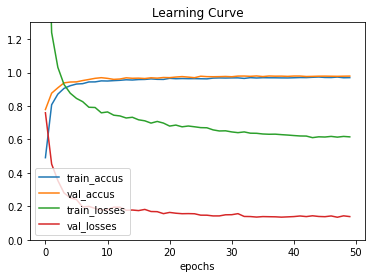

In [ ]:
%matplotlib inline
plt.plot(train_accus)
plt.plot(val_accus)
plt.plot(train_losses)
plt.plot(val_losses)
plt.ylim(0, 1.3)
plt.legend(['train_accus', 'val_accus', 'train_losses', 'val_losses'])
#plt.show()
plt.title('Learning Curve')
plt.xlabel('epochs')

plt.savefig(f'{model_name}_acc98d34.png')

Show how the lr_scheduler works

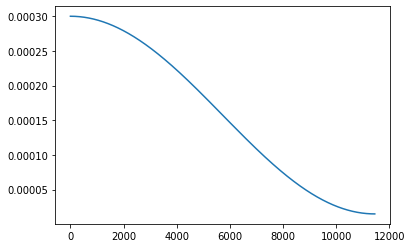

In [ ]:
plt.plot(lrs)

#Use the ensemble of 5 folds to make a prediction (by taking a majority voting)

In [ ]:
files = sorted(os.listdir('./'))
files

In [ ]:
cvss_label = []
for file in files:
  if file.endswith('.csv') and file != 'test.csv' and file != 'train.csv' and file != 'sample_submission.csv':
    print(file)
    cvs_label = pd.read_csv(file)['label'].to_numpy()
    cvss_label.append(cvs_label)
cvss_label = np.array(cvss_label)
cvss_label.shape

In [ ]:
from scipy import stats
final_label = []
for i in range (cvss_label.shape[1]):
  majority_label = stats.mode(cvss_label[:,i])[0][0]
  final_label.append(majority_label)

In [ ]:
test_csv = pd.read_csv('test.csv')
test_csv.head()

In [ ]:
test_csv.insert(1, 'label', final_label)
test_csv.head()

In [ ]:
test_csv.to_csv(os.path.join(save_dir,'submit_ensemble5_e50.csv'), index=False)

#Results

the results obtained by the code above are shown below. Using only one model of the 5 folds, we can obtain 98.181% at private LB (rank 33). Using the ensemble of all the 5 folds, we can obtain 98.363% at private LB (rank21). Using further models (using various settings like using seresnet50, resnest50d, at 224 resolution) to vote -- total of 10 models, we can obtain 98.681% at private LB (rank 13). But it was a late submission, thus I don't have my name on LB :)

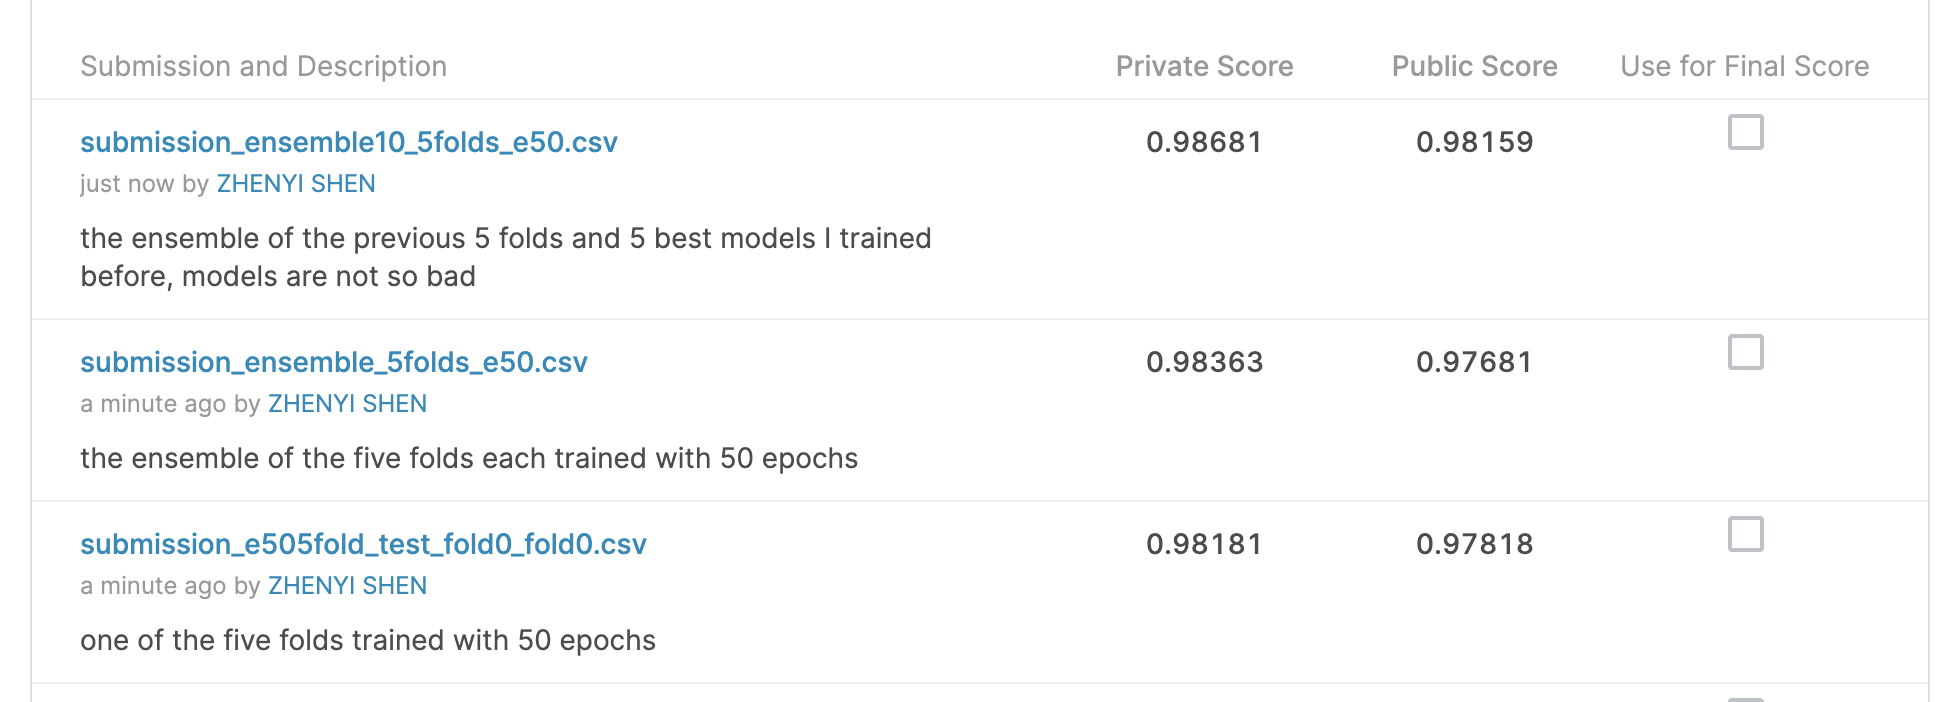